## Area Range Under Definition Changes
How much does area coverage change when we tweak the changes for what is Google and non-Google?
This section examines 6 scenarios

We recalculate the area percentages from Table 1 under our baseline interpretation as well as several other interpretations.

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# variables
subsample = True
data_dir = '../data' if not subsample else '../data_subsample'

In [3]:
# input
fn_metadata = f'{data_dir}/intermediary/element_metadata.jsonl.gz'

# output
fn_plt = f'{data_dir}/output/figures/5-area-range.png'

In [4]:
# we will isolate blue links and "attributed answers"
attributed_answers = [
    'answer-richtext',
    'answer-feature_snippet_answer_short',
    'answer-knowledge_panel_answer',
    'answer-medical',
    'answer-knowledge_health',
    'answer-dictionary',
]

blue_link_categories = [
    'organic-search_result',
    'amp-search_result',
    "youtube-search-result"
]

cols = [
    'area_above_the_fold',
    'area_page'
]

In [5]:
pixels = {
    col : {
        'ad' : 0,
        'bluelink' : 0,
        'non-google-nbl' : 0,
        'google-nbl' : 0,
        'amp-nbl' : 0,
        'non-google': 0,
        'google' : 0,
        'amp' : 0,
        'attributed-answers' : 0,
        'everything' : 0,
        
    } for col in cols
}

for df in tqdm(pd.read_json(fn_metadata, 
                            lines=True, 
                            chunksize=10000)):
    for col in cols:
        # baseline values
        ad = df[df.label == 'ads'][col].sum()
        g = df[(df.label == 'link') | (df.label == 'answer')][col].sum()
        amp = df[df.label == 'amp'][col].sum()
        o = df[df.label == 'organic'][col].sum()
        
        # isolating blue links
        blue =  df[df.category_standard.isin(blue_link_categories)][col].sum()
        o_nbl = df[(df.label == 'organic') & 
               (~df.category_standard.isin(blue_link_categories))][col].sum()
        g_nbl = df[(df.label == 'link') | (df.label == 'answer') & 
                (~df.category_standard.isin(blue_link_categories))][col].sum()
        amp_nbl = df[(df.label == 'amp') & 
                 (~df.category_standard.isin(blue_link_categories))][col].sum()
        
        # scraped answers with attribution links
        aa = df[df.category.isin(attributed_answers)][col].sum()
        
        everything = df[col].sum()
        
        # append area of pixels to dictionary
        pixels[col]['ad'] += ad
        pixels[col]['bluelink'] += blue
        pixels[col]['non-google-nbl'] += o_nbl
        pixels[col]['google-nbl'] += g_nbl
        pixels[col]['amp-nbl'] += amp_nbl
        pixels[col]['non-google'] += o
        pixels[col]['google'] += g
        pixels[col]['amp'] += amp        
        pixels[col]['attributed-answers'] += aa
        pixels[col]['everything'] += everything
   
    del df

4it [00:01,  2.40it/s]


In [6]:
# let's see this for above the fold:
col = cols[0]
col

'area_above_the_fold'

In [7]:
baseline_g =  pixels[col]['google'] / pixels[col]['everything']
baseline_ng =pixels[col]['non-google'] / pixels[col]['everything']
baseline_g, baseline_ng

(0.6209938070106924, 0.20059580494497176)

### Scenario 1
Ads are part of Google

In [8]:
s1_g = (pixels[col]['ad'] + pixels[col]['google']) / pixels[col]['everything']
s1_ng = pixels[col]['non-google'] / pixels[col]['everything']

### Scenario 2
AMP is part of Google

In [9]:
s2_g = (pixels[col]['amp'] + pixels[col]['google']) / pixels[col]['everything']
s2_ng = pixels[col]['non-google'] / pixels[col]['everything']

### Scenario 3
AMP is part of non-Google

In [10]:
s3_g = pixels[col]['google'] / pixels[col]['everything']
s3_ng = (pixels[col]['non-google'] + pixels[col]['amp']) / pixels[col]['everything']

### Scenario 4
All answers with an outbound link are conisdered non-Google

In [11]:
s4_g = (pixels[col]['google'] - 
        pixels[col]['attributed-answers']) / pixels[col]['everything']
s4_ng = (pixels[col]['non-google'] + 
         pixels[col]['attributed-answers']) / pixels[col]['everything']

### Scenario 5
All blue links are folded into Non-Google

In [12]:
s5_g = pixels[col]['google-nbl'] / pixels[col]['everything']

s5_ng = (pixels[col]['bluelink'] + 
 pixels[col]['non-google-nbl']
) / pixels[col]['everything']

### Scenario 6
Blue links replace non-Google. Google is all modules that are not ads or bluelinks.

In [13]:
s6_g = (pixels[col]['google-nbl'] + 
 pixels[col]['amp-nbl'] +
 pixels[col]['non-google-nbl']
) / pixels[col]['everything']

s6_ng = pixels[col]['bluelink'] / pixels[col]['everything']

Let's get the range of these scenarios

In [14]:
ng_range = [s1_ng, s2_ng, s3_ng, s4_ng, s5_ng, s6_ng] 
g_range =  [s1_g,  s2_g,  s3_g,  s4_g,  s5_g,  s6_g ]

In [15]:
g = [min(g_range), 
     max(g_range)]
g

[0.47424984176269347, 0.8127382640021609]

In [16]:
ng = [min(ng_range), 
      max(ng_range)]
ng

[0.12442585661319605, 0.34733977019297074]

In [17]:
data = [{
        'category' : 'Google',
        'frame' : 'Top of Page',
        'area' : baseline_g * 100,
        'min' : g[0]* 100,
        'max' : g[-1]* 100
    },

    {
        'category' : 'non-Google',
        'frame' : 'Top of Page',
        'area' : baseline_ng* 100,
        'min' : ng[0]* 100,
        'max' : ng[-1]* 100
    },
]

In [18]:
data = pd.DataFrame(data)

In [19]:
data['name'] =  data['category']

In [20]:
name2name = {
    'Top of Page non-Google' : 'non-Google',
    'First Page non-Google' : 'non-Google '
}

In [21]:
data = data[::-1]

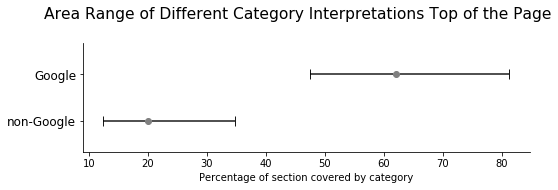

In [22]:
fig, ax = plt.subplots(figsize=(8, 2))
plt.scatter(data.area, data.name, zorder=100, color='grey')

plt.errorbar(data.area, 'name', 
             data=data,
             xerr=[data['area'] -data['min'], 
                   data['max'] - data['area']], 
             ecolor='k', color='white',
             capsize = 5,  fmt='o',
             alpha=.9)

plt.title("Area Range of Different Category Interpretations Top of the Page",
           x=0.48,
           y=1.17,
           size=15.5)

ax.set_xlabel("Percentage of section covered by category")


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.tick_params(axis='y', which='major', labelsize=12)
ax.margins(y=0.6)

plt.savefig(fn_plt)
plt.show()